# Trend Classification with LSTM

### Imports

In [1]:
import os, sys
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from time import time
from tensorflow.python.keras.callbacks import TensorBoard
import warnings
warnings.simplefilter("ignore")

from indicators import *
from data_loading import *
from util_functions import *


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


### Parameters

In [2]:
trail_size=14
predict_length = 5
time_period = '6y'

# 1.0 Load data

In [3]:
top_energy = ["XOM", "CVX", "RDS-A", "RDS-B", "PTR", "TOT", "BP",
"SNP", "ENB", "COP", "EQNR", "PBR-A", "PBR", "EPD",
"TRP", "E", "EOG", "SLB", "KMI", "PSX", "CNQ",
"MPC", "PXD", "SU", "VLO"]

In [4]:
traditional_energy_stocks = [
    "LNG",
    "OKE",
    "BKR",
    "WMB",
    "EQT", 
    "XEC", 
    "XOM", 
    "CVX", 
    "BP", 
    "OXY", 
    "COP", 
    "EOG", 
    "COG", 
    "CNQ", 
    "SLB", 
    "PTR", 
    "TOT", 
    "ENB",  
]

In [5]:
data = get_data_yf(traditional_energy_stocks, time_period)

[*********************100%***********************]  18 of 18 completed


In [6]:
data.isna().sum().sum()

0

In [7]:
data = process_stock_data_from_yf(data)

In [8]:
has_data_ratio, data = filter_has_all_data(data)
has_data_ratio

100.0

In [9]:
### Compute technical indicators

In [10]:
# compute all our technical markers for each of the stocks. 
dataset = data.groupby('Ticker').apply(lambda x: add_technical_markers(x, trail_size))

In [11]:
### Load climate trends data

In [12]:
filenames = [
    "data climate change adjusted.csv",
    "data greenhouse gas adjusted.csv",
    "data oil adjusted.csv",
    "data renewable adjusted.csv",
    "data carbon tax adjusted.csv",
    "data electric vehicles adjusted.csv",
    "data environmental protection agency adjusted.csv",
    "data fossil fuels adjusted.csv",
    "data fracking adjusted.csv",
    "data global warming adjusted.csv",
]
terms = [
    "climate change",
    "greenhouse gas",
    "oil",
    "renewable",
    "carbon tax",
    "electric vehicles",
    "environmental protection agency",
    "fossil fuels",
    "fracking",
    "global warming",
]

In [13]:
climate_trends_data = load_climate_data(filenames, terms)

In [14]:
climate_trends_data.shape

(2278, 11)

In [15]:
num_climate_features = len(climate_trends_data.columns.tolist()) - 1 # minus date

<AxesSubplot:xlabel='Date'>

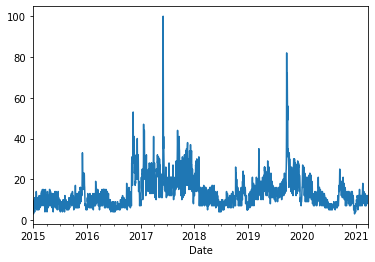

In [16]:
climate_trends_data.set_index('Date')['climate change'].plot()

# 2.0 Prepare dataset of many stocks

### Choose technical features

In [17]:
features = ['Close', 'High',
 'Low', 'Open', 'Volume',
 'HH', 'LL', 'AV',
 'SMA', 'SD', 'WILLR',
 'ATR', 'DMH', 'DML',
 'EMA', 'WMA', 'BBHIGH',
 'BBLOW', 'PERBHIGH', 'PERBLOW',
 'TRIMA', 'RSI', 'DX',
 'PDI', 'NDI', 'ADX',
 'ROC', 'MACD', 'CCI']
dataset = dataset[['Ticker', 'Date'] + features]
num_features = len(features)

### Train test split

In [18]:
train = dataset.loc[dataset['Date'] < "2018-03-01"]
valid = dataset.loc[(dataset['Date'] > "2018-03-13") & (dataset['Date'] < "2019-03-01")]
test = dataset.loc[(dataset['Date'] > "2019-03-01") & (dataset['Date'] < "2020-03-01")]

In [19]:
train.shape

(13230, 31)

In [20]:
test.shape

(4518, 31)

#### Per stock normalization
We make sure to fit the transforms on the training, and
apply them on training, validation, and test

In [21]:
scaler_models = norm_per_stock_split(train, valid, test, features, MinMaxScaler)

### Merge in the climate data

In [22]:
train = train.merge(climate_trends_data, on=["Date"], how='left')
valid = valid.merge(climate_trends_data, on=["Date"], how='left')
test = test.merge(climate_trends_data, on=["Date"], how='left')

#### Prepare training inputs and outputs
Convert the daily data points into a set of data points each with {trail_size} days.   
We keep track of the tickers so we can later inverse the normalization with the right model. 

In [23]:
x_train, y_train, tickers_train = roll_all_stocks(train, trail_size, predict_length, trend_classify=True)
x_valid, y_valid, tickers_valid = roll_all_stocks(valid, trail_size, predict_length, trend_classify=True)
x_test, y_test, tickers_test = roll_all_stocks(test, trail_size, predict_length, trend_classify=True)

In [24]:
num_features+=num_climate_features

In [25]:
#### Confirm shapes

In [26]:
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_valid: {}".format(x_valid.shape))
print("y_valid {}".format(y_valid.shape))
print("x_test: {}".format(x_test.shape))
print("y_test {}".format(y_test.shape))

x_train: (12654, 14, 39)
y_train: (12654,)
x_valid: (4032, 14, 39)
y_valid (4032,)
x_test: (4180, 14, 39)
y_test (4180,)


In [27]:
np.mean(y_train)

0.4973131025762605

In [28]:
np.mean(y_valid)

0.5277777777777778

In [29]:
np.mean(y_test)

0.47033492822966505

### Model design

In [30]:
model = Sequential()
model.add(LSTM(units=75, input_shape=(trail_size, num_features), return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dense(50, activation='relu'))
# model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 75)            34500     
_________________________________________________________________
dropout (Dropout)            (None, 14, 75)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 30)            12720     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 14, 30)            7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
flatten (Flatten)            (None, 420)               0

In [32]:
time_stamp = time()
tensorboard = TensorBoard(log_dir='logs/{}'.format(time_stamp))

In [33]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [34]:
history1 = model.fit(x_train, 
                     y_train, 
                     epochs=30, 
                     validation_data=(x_valid, y_valid), 
                     batch_size=64, 
                     shuffle=True, 
                     callbacks=[tensorboard])

Epoch 1/30
198/198 [==============================] - 9s 22ms/step - loss: 0.6881 - accuracy: 0.5361 - val_loss: 0.7275 - val_accuracy: 0.5312
Epoch 2/30
198/198 [==============================] - 2s 11ms/step - loss: 0.6674 - accuracy: 0.5943 - val_loss: 0.7911 - val_accuracy: 0.5278
Epoch 3/30
198/198 [==============================] - 2s 10ms/step - loss: 0.6482 - accuracy: 0.6256 - val_loss: 0.8707 - val_accuracy: 0.5278
Epoch 4/30
198/198 [==============================] - 2s 10ms/step - loss: 0.6219 - accuracy: 0.6594 - val_loss: 0.7790 - val_accuracy: 0.4831
Epoch 5/30
198/198 [==============================] - 2s 10ms/step - loss: 0.6048 - accuracy: 0.6788 - val_loss: 0.8030 - val_accuracy: 0.5027
Epoch 6/30
198/198 [==============================] - 2s 10ms/step - loss: 0.5863 - accuracy: 0.6933 - val_loss: 0.8134 - val_accuracy: 0.4883
Epoch 7/30
198/198 [==============================] - 2s 10ms/step - loss: 0.5640 - accuracy: 0.7118 - val_loss: 0.8043 - val_accuracy: 0.4973

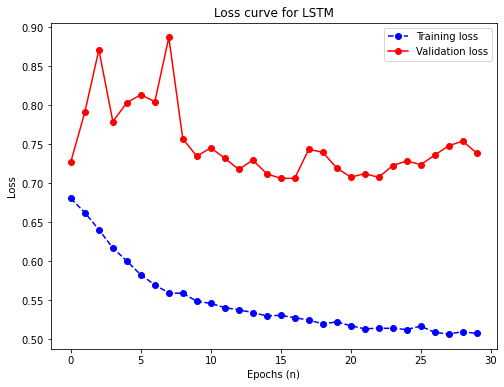

In [35]:
plot_loss(history1)

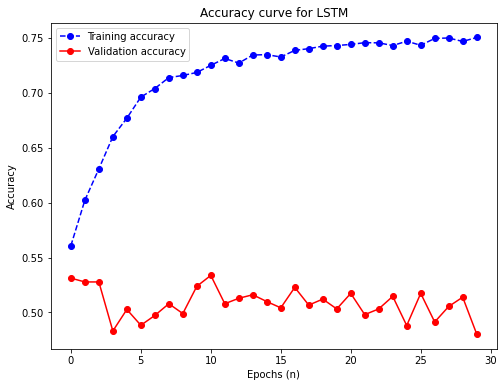

In [36]:
plot_acc(history1)

#### Performance of model

In [37]:
performance_stats(model, x_train, y_train)

Upward ratio: 0.4973131025762605
Mean prediction: 0.47685664892196655
Predicted upward ratio: 0.46119804014540855
Accuracy: 0.7664770033191086


In [38]:
performance_stats(model, x_valid, y_valid)

Upward ratio: 0.5277777777777778
Mean prediction: 0.5948706269264221
Predicted upward ratio: 0.8043154761904762
Accuracy: 0.48040674603174605


In [39]:
performance_stats(model, x_test, y_test)

Upward ratio: 0.47033492822966505
Mean prediction: 0.6041234135627747
Predicted upward ratio: 0.7811004784688995
Accuracy: 0.533732057416268


# 3.0 Prepare data for one stock

In [40]:
target_stock = 'XOM'

In [41]:
single_stock_dataset = dataset[dataset['Ticker']==target_stock].reset_index(drop=True)

<AxesSubplot:xlabel='Date', ylabel='Close'>

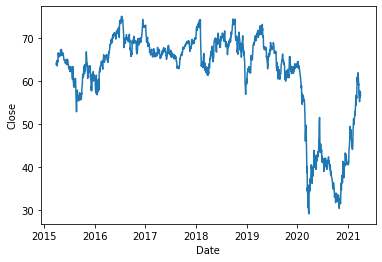

In [42]:
sns.lineplot(x=single_stock_dataset['Date'], y=single_stock_dataset['Close'])

In [43]:
train = single_stock_dataset.loc[single_stock_dataset['Date'] < "2018-03-01"]
valid = single_stock_dataset.loc[(single_stock_dataset['Date'] > "2018-03-13") & (single_stock_dataset['Date'] < "2019-03-01")]
test = single_stock_dataset.loc[(single_stock_dataset['Date'] > "2019-03-01") & (single_stock_dataset['Date'] < "2020-03-01")]

In [44]:
single_stock_scaler_models = norm_per_stock_split(train, valid, test, features, MinMaxScaler)

In [45]:
train = train.merge(climate_trends_data, on=["Date"], how='left')
valid = valid.merge(climate_trends_data, on=["Date"], how='left')
test = test.merge(climate_trends_data, on=["Date"], how='left')

#### Prepare training inputs and outputs

In [46]:
x_train, y_train, _ = roll_all_stocks(train, trail_size, predict_length, trend_classify=True)
x_valid, y_valid, _ = roll_all_stocks(valid, trail_size, predict_length, trend_classify=True)
x_test, y_test, _ = roll_all_stocks(test, trail_size, predict_length, trend_classify=True)

In [47]:
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_valid: {}".format(x_valid.shape))
print("y_valid {}".format(y_valid.shape))
print("x_test: {}".format(x_test.shape))
print("y_test {}".format(y_test.shape))

x_train: (703, 14, 39)
y_train: (703,)
x_valid: (224, 14, 39)
y_valid (224,)
x_test: (233, 14, 39)
y_test (233,)


In [49]:
# model.layers[7].trainable = False
# model.layers[4].trainable = False
# model.layers[2].trainable = False
# model.layers[0].trainable = False

In [50]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Train model on single stock

In [51]:
tensorboard = TensorBoard(log_dir='logs/{}_2'.format(time_stamp))

In [52]:
history2 = model.fit(x_train, 
                     y_train, 
                     epochs=20, 
                     validation_data=(x_valid, y_valid), 
                     batch_size=64, 
                     shuffle=True, 
                     callbacks=[tensorboard])

Epoch 1/20
11/11 [==============================] - 8s 495ms/step - loss: 0.5599 - accuracy: 0.7173 - val_loss: 0.7287 - val_accuracy: 0.5268
Epoch 2/20
11/11 [==============================] - 0s 12ms/step - loss: 0.4420 - accuracy: 0.8049 - val_loss: 0.7487 - val_accuracy: 0.5179
Epoch 3/20
11/11 [==============================] - 0s 13ms/step - loss: 0.4510 - accuracy: 0.7915 - val_loss: 0.7645 - val_accuracy: 0.5134
Epoch 4/20
11/11 [==============================] - 0s 13ms/step - loss: 0.4149 - accuracy: 0.8246 - val_loss: 0.7865 - val_accuracy: 0.4911
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 0.3946 - accuracy: 0.8135 - val_loss: 0.8278 - val_accuracy: 0.5223
Epoch 6/20
11/11 [==============================] - 0s 13ms/step - loss: 0.3700 - accuracy: 0.8378 - val_loss: 0.8327 - val_accuracy: 0.5000
Epoch 7/20
11/11 [==============================] - 0s 14ms/step - loss: 0.3654 - accuracy: 0.8366 - val_loss: 0.8620 - val_accuracy: 0.4911
Epoch 8/20
1

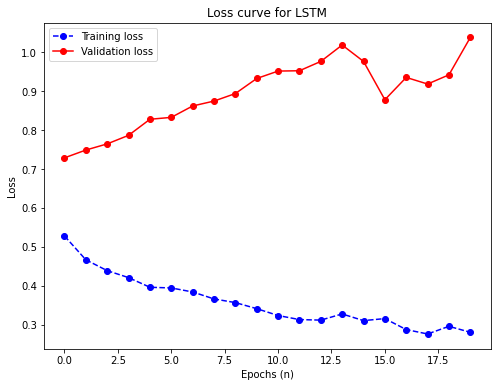

In [53]:
plot_loss(history2)

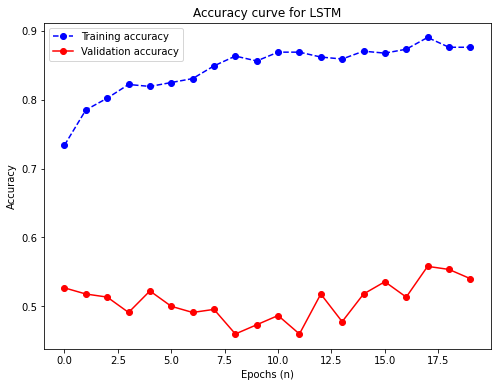

In [54]:
plot_acc(history2)

#### Model performance

In [55]:
performance_stats(model, x_train, y_train)

Upward ratio: 0.5320056899004267
Mean prediction: 0.531935453414917
Predicted upward ratio: 0.5391180654338549
Accuracy: 0.9103840682788051


In [56]:
performance_stats(model, x_valid, y_valid)

Upward ratio: 0.5848214285714286
Mean prediction: 0.7080590128898621
Predicted upward ratio: 0.7767857142857143
Accuracy: 0.5401785714285714


In [57]:
performance_stats(model, x_test, y_test)

Upward ratio: 0.4206008583690987
Mean prediction: 0.48047253489494324
Predicted upward ratio: 0.4592274678111588
Accuracy: 0.6008583690987125
